In [ ]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
images_part_1 = os.path.join(base_dir, 'ham10000_images_part_1')
images_part_2 = os.path.join(base_dir, 'ham10000_images_part_2')
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')
data_dir = '/kaggle/working/data'

# Read metadata
df = pd.read_csv(metadata_path)

# Define classes
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Split data with stratification
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

# Check class distribution in training set
class_counts = train_df['dx'].value_counts()
print("Class distribution in training set:\n", class_counts)

# Check if 'nv' is the majority and downsample if necessary
if class_counts.idxmax() == 'nv':
    nv_count = class_counts['nv']
    # Find the count of the second most frequent class
    second_highest_count = class_counts[class_counts.index != 'nv'].max()
    print(f"'nv' is the majority class with {nv_count} samples. Downsampling to {second_highest_count} samples.")

    # Downsample 'nv' class
    nv_df = train_df[train_df['dx'] == 'nv']
    other_df = train_df[train_df['dx'] != 'nv']
    nv_downsampled = nv_df.sample(n=second_highest_count, random_state=42)

    # Update train_df with downsampled data
    train_df = pd.concat([other_df, nv_downsampled])

    # Verify new class distribution
    print("New class distribution in training set:\n", train_df['dx'].value_counts())
else:
    print("'nv' is not the majority class. No downsampling needed.")

Class distribution in training set:
 dx
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64
'nv' is the majority class with 4693 samples. Downsampling to 779 samples.
New class distribution in training set:
 dx
mel      779
nv       779
bkl      769
bcc      360
akiec    229
vasc      99
df        81
Name: count, dtype: int64


In [ ]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
images_part_1 = os.path.join(base_dir, 'ham10000_images_part_1')
images_part_2 = os.path.join(base_dir, 'ham10000_images_part_2')
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')
data_dir = '/kaggle/working/data'

# Read metadata
df = pd.read_csv(metadata_path)

# Build image paths dictionary
image_paths = {}
for folder in [images_part_1, images_part_2]:
    for img in os.listdir(folder):
        if img.endswith('.jpg'):
            image_id = img.split('.')[0]
            image_paths[image_id] = os.path.join(folder, img)

# Define classes
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Split data with stratification
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

# Check class distribution in training set
class_counts = train_df['dx'].value_counts()
print("Class distribution in training set:\n", class_counts)

# Check if 'nv' is the majority and downsample if necessary
if class_counts.idxmax() == 'nv':
    nv_count = class_counts['nv']
    # Find the count of the second most frequent class
    second_highest_count = class_counts[class_counts.index != 'nv'].max()
    print(f"'nv' is the majority class with {nv_count} samples. Downsampling to {second_highest_count} samples.")

    # Downsample 'nv' class
    nv_df = train_df[train_df['dx'] == 'nv']
    other_df = train_df[train_df['dx'] != 'nv']
    nv_downsampled = nv_df.sample(n=second_highest_count, random_state=42)

    # Update train_df with downsampled data
    train_df = pd.concat([other_df, nv_downsampled])

    # Verify new class distribution
    print("New class distribution in training set:\n", train_df['dx'].value_counts())
else:
    print("'nv' is not the majority class. No downsampling needed.")

# Create directory structure
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(data_dir, split, cls), exist_ok=True)

# Function to copy images to respective directories
def copy_images(df, split):
    for _, row in df.iterrows():
        image_id = row['image_id']
        cls = row['dx']
        src = image_paths[image_id]
        dst = os.path.join(data_dir, split, cls, f"{image_id}.jpg")
        shutil.copy(src, dst)

# Copy images to directories
copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')

Class distribution in training set:
 dx
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64
'nv' is the majority class with 4693 samples. Downsampling to 779 samples.
New class distribution in training set:
 dx
mel      779
nv       779
bkl      769
bcc      360
akiec    229
vasc      99
df        81
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings, allow info logs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')  # Suppress Keras UserWarnings
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Enhanced data augmentation for training with normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
)


val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Create generators with proper steps and updated image size
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4178 images belonging to 7 classes.
Found 1988 images belonging to 7 classes.


In [ ]:
!pip install --upgrade tensorflow
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 90.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.4 MB/s eta 0:00:0000:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define shape and number of classes
input_shape = (299, 299, 3)  # Larger image size to better suit Xception
n_classes = 7

# Load base model without top
base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze base model for Phase 1
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(64)(x)
x = Dropout(0.65)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
output = Dense(n_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['dx']), y=train_df['dx'])
class_weight_dict = dict(enumerate(class_weights))

In [ ]:

### Phase 1: Train top layers only
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n📌 Phase 1: Training top layers only...\n")
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict
)




📌 Phase 1: Training top layers only...

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.3408 - loss: 1.6613 - val_accuracy: 0.5910 - val_loss: 1.2378 - learning_rate: 0.0010
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 132s 963ms/step - accuracy: 0.3351 - loss: 1.5654 - val_accuracy: 0.6494 - val_loss: 1.0982 - learning_rate: 0.0010
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 131s 956ms/step - accuracy: 0.3747 - loss: 1.4934 - val_accuracy: 0.5448 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 942ms/step - accuracy: 0.3857 - loss: 1.4907 - val_accuracy: 0.6112 - val_loss: 1.1637 - learning_rate: 0.0010
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 941ms/step - accuracy: 0.4085 - loss: 1.4302 - val_accuracy: 0.5850 - val_loss: 1.2019 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [ ]:
# Suppress TensorFlow warnings and configure GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings, allow info logs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
os.environ['TF_XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'  # Optimize XLA

In [ ]:
### Phase 2: Fine-tune full model
for layer in base_model.layers:
    layer.trainable = True  # Unfreeze all layers

# Re-compile with lower LR
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n📌 Phase 2: Fine-tuning the entire model...\n")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict
)


📌 Phase 2: Fine-tuning the entire model...

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.4763 - loss: 1.2149 - val_accuracy: 0.6464 - val_loss: 1.0351 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5734 - loss: 1.0072 - val_accuracy: 0.7269 - val_loss: 1.0066 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6262 - loss: 0.8885 - val_accuracy: 0.7455 - val_loss: 0.9467 - learning_rate: 1.0000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6661 - loss: 0.8212 - val_accuracy: 0.7425 - val_loss: 1.0166 - learning_rate: 1.0000e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7140 - loss: 0.7132 - val_accuracy: 0.7304 - val_loss: 0.9840 - learning_rate: 1.0000e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7363 - loss: 0.6658 - val_accuracy: 0.6660 - val_loss: 1.0830 - learning_rate: 1.0000e-04
Epoch 7/50
13

In [ ]:
# Load test generator (same settings as val)
test_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n📊 Test Loss: {test_loss:.4f} — Test Accuracy: {test_accuracy:.4f}")

Found 1986 images belonging to 7 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.8294 - loss: 0.6316

📊 Test Loss: 0.5796 — Test Accuracy: 0.8525


In [ ]:
model.save("Skin Cancer Detector - edited.h5")

Found 1986 images belonging to 7 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.8294 - loss: 0.6316

📊 Test Loss: 0.5796 — Test Accuracy: 0.8525
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step

Classification Report:

              precision    recall  f1-score   support

       akiec       0.95      0.61      0.74        66
         bcc       0.84      0.87      0.85       100
         bkl       0.72      0.87      0.79       218
          df       0.61      0.96      0.74        24
         mel       0.57      0.76      0.65       220
          nv       0.96      0.87      0.91      1330
        vasc       0.67      0.93      0.78        28

    accuracy                           0.85      1986
   macro avg       0.76      0.84      0.78      1986
weighted avg       0.88      0.85      0.86      1986



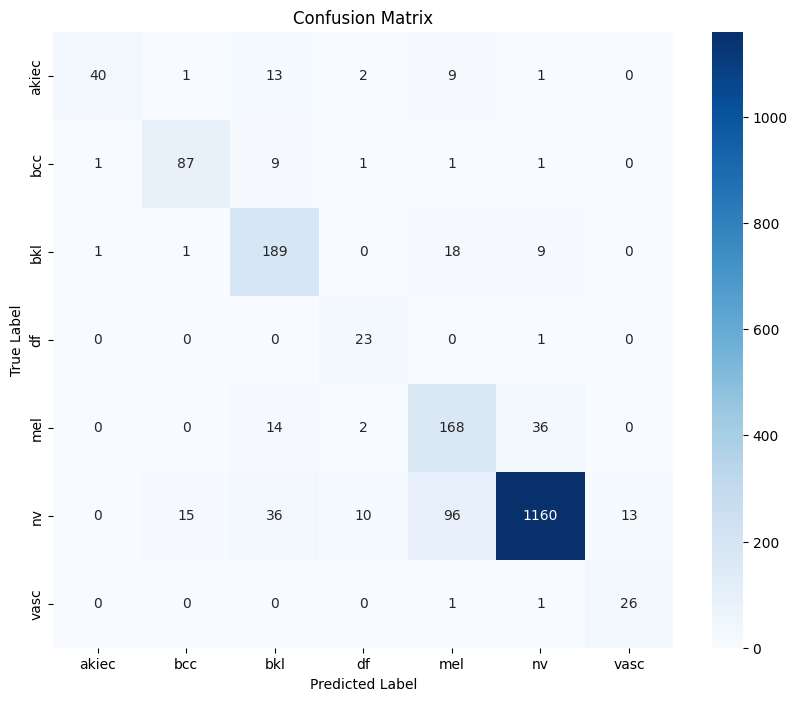

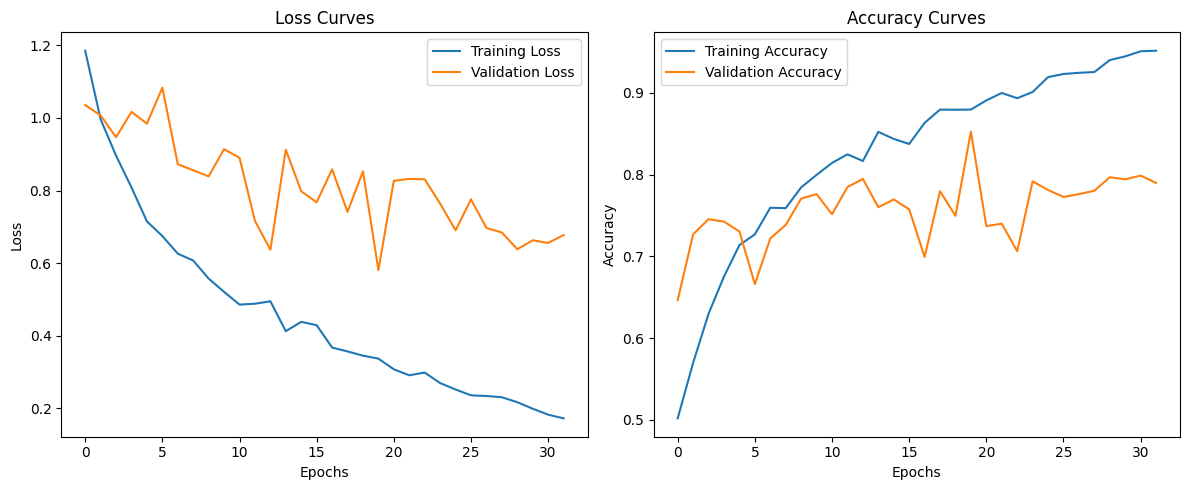

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load test generator
test_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n📊 Test Loss: {test_loss:.4f} — Test Accuracy: {test_accuracy:.4f}")

# Classification Report
y_true = test_generator.classes  # Ground truth labels
y_pred = model.predict(test_generator)  # Predicted probabilities
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels
class_labels = list(test_generator.class_indices.keys())  # Class names
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Loss and Accuracy Curves (if history is available)
if 'history' in locals():
    plt.figure(figsize=(12, 5))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()